In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [198]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(rwantshue)

In [340]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [341]:
%%R
physeq = subset_samples(physeq,sample_sums(physeq)>1)

In [345]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Trtmt,Month){
    physeq.pruned <- prune_samples(((sample_data(physeq)$Month == Month) & (sample_data(physeq)$Trtmt == Trtmt)) | ((sample_data(physeq)$Month == Month) & (sample_data(physeq)$Trtmt == "Quartz")),physeq)
    physeq.pruned = prune_taxa(taxa_sums(physeq.pruned) > 0, physeq.pruned)
#    physeq.pruned = prune_samples(sample_sums(physeq.pruned)>200, physeq.pruned)
    taxonomy <- data.frame(tax_table(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Trtmt)
    dseq$Trtmt = relevel(dseq$Trtmt,"Quartz")
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq)
    results$Month = Month
    results$Trtmt = Trtmt
    results = data.frame(results$Month,results$Trtmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
    colnames(results) = c("Month","Trtmt","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
    results
    }

In [350]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Trtmt = c("Ferrihydrite"),
                        Month = c(2.5, 3))
variables

         Trtmt Month
1 Ferrihydrite   2.5
2 Ferrihydrite   3.0


In [351]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode


In [352]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

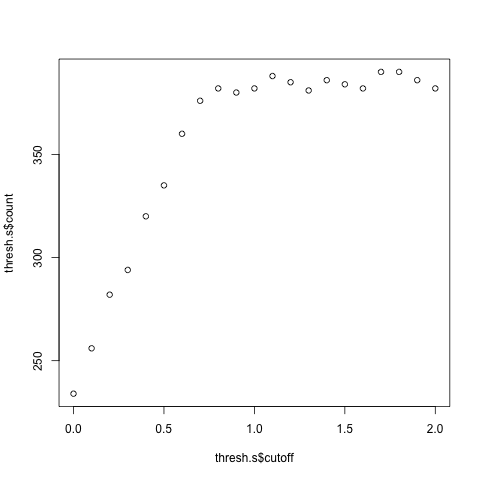

In [358]:
%%R
range = seq(0,2,0.1)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.3)

In [359]:
%%R
filter(DA,baseMean>=0.8) %>% mutate(padj = p.adjust(pvalue,"BH")) %>% write.csv("../../SeqData/l2fcQF.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [360]:
%%R
l2fc<-read.csv("../../SeqData/l2fcQF.csv")
head(l2fc)

  Month        Trtmt        OTU  baseMean       l2FC        SE     pvalue
1   2.5 Ferrihydrite  52_374818 1.0641535 -0.8478144 1.2709841 0.50473796
2   2.5 Ferrihydrite 95_1222810 0.8217720  0.7523777 1.0479521 0.47278784
3   2.5 Ferrihydrite  65_942692 5.3521427  0.1038058 0.7236544 0.88593746
4   2.5 Ferrihydrite   7_125682 6.5612145  1.2138643 0.5611620 0.03053146
5   2.5 Ferrihydrite  58_735746 4.3238295 -0.4906355 0.6404516 0.44363020
6   2.5 Ferrihydrite  72_362859 0.8648982 -0.1329234 1.0203617 0.89635216
   Kingdom         Phylum              Class        Order        Family
1 Bacteria  Acidobacteria         Holophagae Holophagales Holophagaceae
2 Bacteria Proteobacteria Betaproteobacteria      SC-I-84          <NA>
3 Bacteria Proteobacteria Betaproteobacteria      SC-I-84          <NA>
4 Bacteria Proteobacteria Betaproteobacteria      SC-I-84          <NA>
5 Bacteria Proteobacteria Betaproteobacteria      SC-I-84          <NA>
6 Bacteria Proteobacteria Betaproteobacteria      

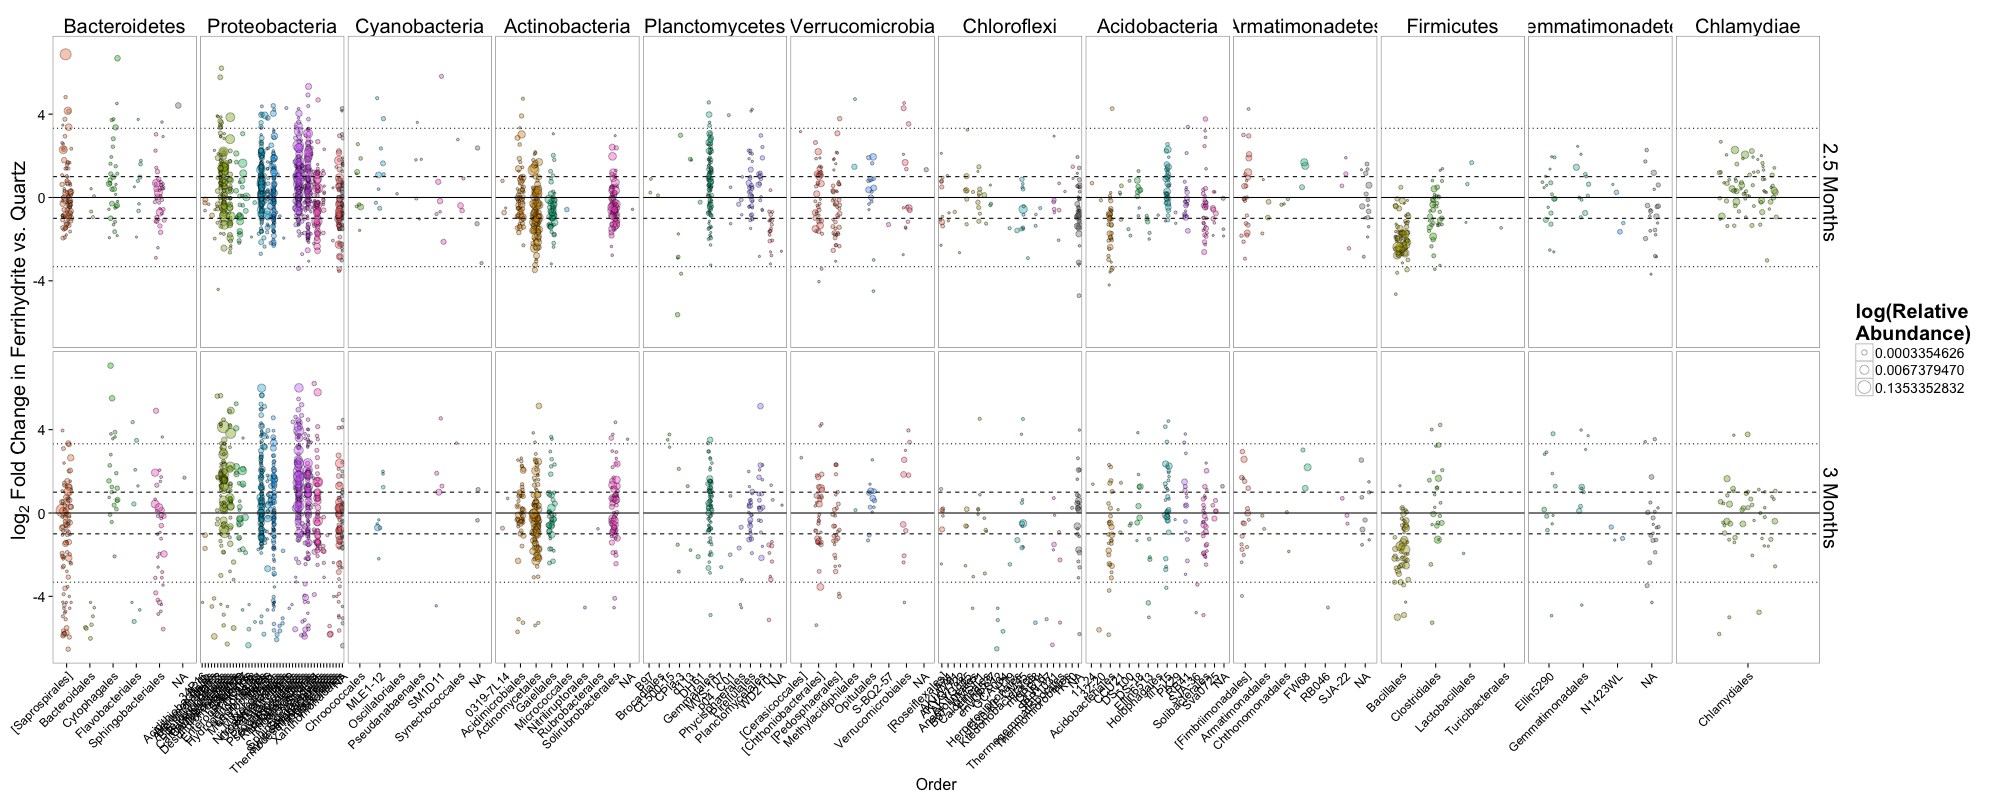

In [367]:
%%R -w 2000 -h 800
# setting the image sizes, then making the figure...

d = l2fc

d = dplyr::group_by(d, Trtmt, Month) %>%
                dplyr::mutate(relabund=baseMean/sum(baseMean))
head(d$relabund)

N=50

Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)    

    
d$MonthName = ifelse(d$Month==2,"2 Months",(ifelse(d$Month==2.5, "2.5 Months","3 Months")))
d$strip1 = paste(d$MonthName)
# Creates a "strip" column of d with Months

max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values

p = ggplot(d, aes(x = Order, y = l2FC, fill = Order, size = relabund))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~strip1~Phylum, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, alpha = 0.4, position = position_jitter(w = 0.20), aes(size = relabund))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)", trans="log")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Order")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," Fold Change in Ferrihydrite vs. Quartz",sep="")))
# sets the label for the y axes.


#p = p + scale_color_continuous(trans="log")    
p = p + scale_fill_discrete(guide="none")
    
#colourCount = length(unique(d$Order))
#getPalette = colorRampPalette(brewer.pal(8, "Dark2"))
#p = p + scale_colour_manual(values=getPalette(colourCount))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [396]:
%%R

cutoff=3.3

d.high = l2fc %>%
# Take the l2fc data frame,
    dplyr::filter(l2FC>cutoff, padj<0.1)%>%
# Include only the 2.5 month samples and take the rows where
# log2fold change is higher than cutoff, and the FDR (padj) is less than 0.1.
    dplyr::group_by(Month) %>%
# Then, treating each month separately,
    dplyr::mutate(relabund=baseMean/sum(baseMean)) %>%
# Create a new column called relabund, which is the mean normalized count, divided by the total
# (total of those we selected, not of the whole dataset). 
    dplyr::group_by(Family, Month) %>%
# Then, using this data, still grouped by month, we further group it by phylum,
    dplyr::summarise(relabund=sum(relabund))
# And we tally up all the relative counts for each taxonomic group.

colnames(d.high) <- c("Tax","Month","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.high, .(Tax), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
d.high$Tax = factor(d.high$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the phyla by abundance
d.high<-d.high[with(d.high, order(Tax)),]
# Sort the whole dataframe by this phylum order


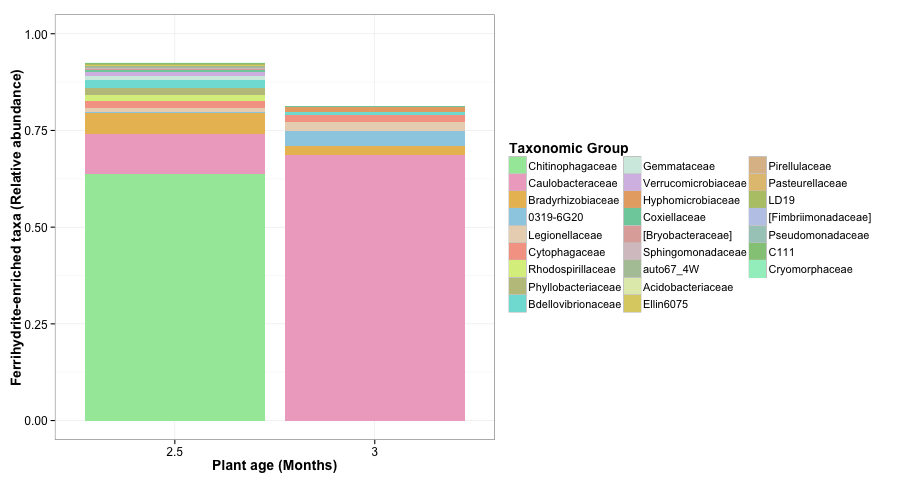

In [397]:
%%R -w 900

d.plot = d.high

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)
d.plot$Month <- as.factor(d.plot$Month)

p = ggplot(d.plot, aes(x=Month,y=relabund,fill = Tax))

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="Taxonomic Group", ncol = 3))

p = p + xlab("Plant age (Months)") + ylab("Ferrihydrite-enriched taxa (Relative abundance)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11))
p = p + theme(legend.title=element_text(size=14))

p

Rhodospirillales (enriched in F at 2.5 months) is mostly purple nonsulfur bacteria (includes magnetospirillum!)  
Chitinophaga still enriched in F at 2.5 months  
Devosia (somewhat enriched at 2.5 and highly enriched at 3 months) may be flagellated gram- bact. from Rhizobiales (alpha-proteo)